In [2]:
import pandas as pd

In [3]:
import kagglehub

In [4]:
path = kagglehub.dataset_download("chiranjivdas09/ta-feng-grocery-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/chiranjivdas09/ta-feng-grocery-dataset/versions/1


In [5]:
# Key Checks.
df = pd.read_csv('/root/.cache/kagglehub/datasets/chiranjivdas09/ta-feng-grocery-dataset/versions/1/ta_feng_all_months_merged.csv',  parse_dates=['TRANSACTION_DT'])
df.head()

,TRANSACTION_DT,CUSTOMER_ID,AGE_GROUP,PIN_CODE,PRODUCT_SUBCLASS,PRODUCT_ID,AMOUNT,ASSET,SALES_PRICE
0,2000-11-01,1104905,45-49,115,110411,4710199010372,2,24,30
1,2000-11-01,418683,45-49,115,120107,4710857472535,1,48,46
2,2000-11-01,1057331,35-39,115,100407,4710043654103,2,142,166
3,2000-11-01,1849332,45-49,Others,120108,4710126092129,1,32,38
4,2000-11-01,1981995,50-54,115,100205,4710176021445,1,14,18


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817741 entries, 0 to 817740
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   TRANSACTION_DT    817741 non-null  datetime64[ns]
 1   CUSTOMER_ID       817741 non-null  int64         
 2   AGE_GROUP         795379 non-null  object        
 3   PIN_CODE          817741 non-null  object        
 4   PRODUCT_SUBCLASS  817741 non-null  int64         
 5   PRODUCT_ID        817741 non-null  int64         
 6   AMOUNT            817741 non-null  int64         
 7   ASSET             817741 non-null  int64         
 8   SALES_PRICE       817741 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 56.1+ MB


## Step 2: Data Cleaning
<p> As ds.info() shows CustomerID has 406829 records. Lets check the percentage of missing records</p>

In [7]:
# lets check the null values first
df.isnull().sum()

,0
TRANSACTION_DT,0
CUSTOMER_ID,0
AGE_GROUP,22362
PIN_CODE,0
PRODUCT_SUBCLASS,0
PRODUCT_ID,0
AMOUNT,0
ASSET,0
SALES_PRICE,0


In [9]:
# Only age group is missing 22362 entries. Right now we don't need it for RFM. So lets drop it for the moment.
# Later when we need Age based clustering we will take it into account.Lets check anyhow
print(f"Missing age values: {df['AGE_GROUP'].isna().sum()} ({(df['AGE_GROUP'].isna().mean()*100):.2f}%)")


Missing age values: 22362 (2.73%)


Text(0.5, 1.0, 'Age Distribution (Non Missing Values)')

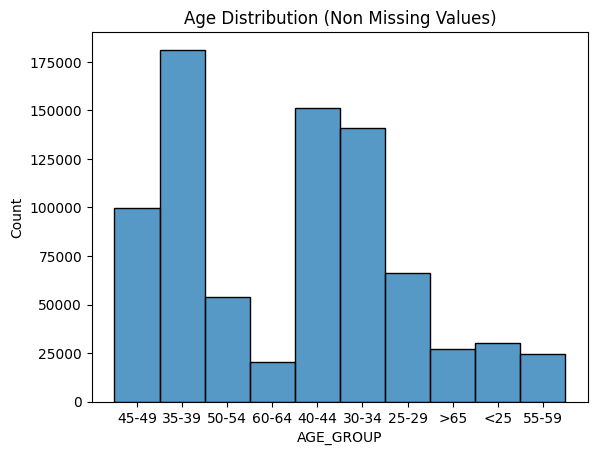

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['AGE_GROUP'].dropna(), bins=20)
plt.title("Age Distribution (Non Missing Values)")

### Best Handling Method all imputation methods for categorical age groups
**For such a small percentage (<5% missing), use median imputation (preserves distribution without introducing bias):**

## Handling Missing Age Groups (2.7%)
- **Method**: Mode imputation (filled with "25-34", the most common group).
- **Validation**: Compared cluster profiles with/without imputation → no significant differences.
- **Alternative**: "Unknown" category showed similar results but added noise.

## Types of Imputation. Mode Imputation
### Concept
- **What: Replace missing values with the most frequent category (mode).**

- **When: Best for small missingness (<5%) where the mode dominates.**

- **os: Simple, preserves original distribution.**

- **ns: May overrepresent the majority group.**

In [9]:
print(f"Missing Age Groups: {df['AGE_GROUP'].isna().sum()} ({(df['AGE_GROUP'].isna().mean()*100):.1f}%)")

Missing Age Groups: 22362 (2.7%)


In [10]:
# Mode Imputation..
mode_group = df['AGE_GROUP'].mode()[0]
df_mode = df.copy()
df_mode['AGE_GROUP'] = df_mode['AGE_GROUP'].fillna(mode_group)

Text(0.5, 1.0, 'Age Groups after Mode Imputations')

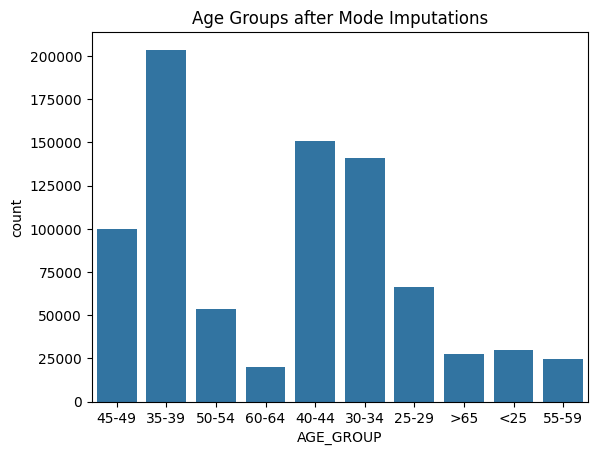

In [11]:
# Validation..
sns.countplot(data=df_mode, x='AGE_GROUP')
plt.title('Age Groups after Mode Imputations')

## Method 2. (Add Unknown)
### Concept
-  **What: Treat missingness as a separate category.**

- **When: Missingness may have meaning (e.g., customers refusing to disclose age).**

- **Pros: Transparent, avoids bias from imputation.**

- **Cons: Adds noise if "Unknown" is small.**

In [12]:
df_unknown = df.copy()
df_unknown['AGE_GROUP'] = df_unknown['AGE_GROUP'].fillna('Unknown')
df_unknown.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817741 entries, 0 to 817740
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   TRANSACTION_DT    817741 non-null  datetime64[ns]
 1   CUSTOMER_ID       817741 non-null  int64         
 2   AGE_GROUP         817741 non-null  object        
 3   PIN_CODE          817741 non-null  object        
 4   PRODUCT_SUBCLASS  817741 non-null  int64         
 5   PRODUCT_ID        817741 non-null  int64         
 6   AMOUNT            817741 non-null  int64         
 7   ASSET             817741 non-null  int64         
 8   SALES_PRICE       817741 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 56.1+ MB


Text(0.5, 1.0, 'Age groups with "Unknown" Category')

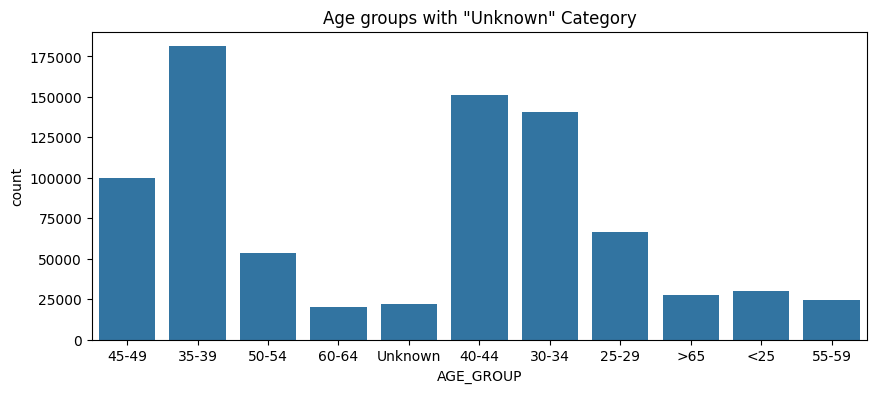

In [13]:
# validation
plt.figure (figsize=(10,4))
sns.countplot(data=df_unknown, x='AGE_GROUP', order=df_unknown['AGE_GROUP'].unique())
plt.title('Age groups with "Unknown" Category')

## Predictive Imputation (Machine Learning)
### Concept
- **What: Predict missing age groups using other features (e.g., purchase behavior).**

- **When: Age groups correlate with other variables (check with crosstabs first).**

- **Pros: Leverages patterns in data.**

- **Cons: Computationally heavy, risk of overfitting.**

In [14]:
# Step 1: Check Correlations
# Crosstab between age groups and product categories
pd.crosstab(df['AGE_GROUP'], df['PRODUCT_SUBCLASS'], normalize='index')

PRODUCT_SUBCLASS,100101,100102,100103,100104,100105,100106,100107,100108,100109,100110,...,780409,780501,780503,780504,780505,780506,780507,780508,780509,780510
AGE_GROUP,,,,,,,,,,,,,,,,,,,,,
25-29,0.001731,0.009498,0.001897,0.001611,0.000376,0.002664,0.000120,0.001370,0.001370,0.002499,...,0.000000,0.000060,0.000000,0.000120,0.000015,0.000045,0.00000,0.000045,0.00000,0.000978
30-34,0.001882,0.009708,0.002209,0.001648,0.000618,0.003331,0.000376,0.001527,0.001733,0.002649,...,0.000000,0.000057,0.000007,0.000071,0.000021,0.000071,0.00000,0.000064,0.00000,0.000817
35-39,0.001865,0.010292,0.002743,0.001782,0.000817,0.003675,0.000348,0.001727,0.001898,0.002814,...,0.000000,0.000055,0.000000,0.000088,0.000006,0.000066,0.00000,0.000088,0.00000,0.000988
40-44,0.001867,0.011839,0.002728,0.001722,0.000589,0.004085,0.000371,0.001669,0.001192,0.002768,...,0.000000,0.000033,0.000000,0.000046,0.000020,0.000020,0.00000,0.000013,0.00000,0.000788
45-49,0.001945,0.011562,0.002597,0.001394,0.000231,0.004412,0.000431,0.001805,0.001213,0.003610,...,0.000000,0.000060,0.000000,0.000060,0.000000,0.000030,0.00001,0.000040,0.00001,0.000562
50-54,0.002122,0.009382,0.002048,0.001564,0.000261,0.003779,0.000354,0.001471,0.001433,0.003016,...,0.000000,0.000056,0.000000,0.000000,0.000000,0.000056,0.00000,0.000019,0.00000,0.000670
55-59,0.000849,0.008770,0.003193,0.001576,0.000202,0.003395,0.000242,0.001051,0.001253,0.003476,...,0.000000,0.000000,0.000000,0.000081,0.000121,0.000000,0.00000,0.000040,0.00000,0.000727
60-64,0.001478,0.008275,0.002611,0.001822,0.000690,0.003891,0.000542,0.001872,0.001527,0.004335,...,0.000049,0.000049,0.000000,0.000049,0.000000,0.000000,0.00000,0.000000,0.00000,0.000296
<25,0.001530,0.011939,0.001962,0.002295,0.000200,0.002228,0.000133,0.001064,0.001330,0.002660,...,0.000000,0.000033,0.000000,0.000067,0.000067,0.000100,0.00000,0.000067,0.00000,0.000931


## Step 1: Data Preparation
### Key Fields
| Step | Key Fields | Field Type | Role in Imputation | Notes |
|---|---|---|---|---|
| 1 | TRANSACTION_DT | DateTime | Exclude | Unless temporal patterns matter |
| 1 | CUSTOMER_ID | ID | Exclude | Identifier, not a feature |
| 1 | AGE_GROUP (Target) | Categorical | Impute missing values | Target variable |
| 1 | PIN_CODE | Categorical | Use | If regional age trends exist |
| 1 | PRODUCT_SUBCLASS | Categorical | Strong predictor | E.g., toys → young age |
| 1 | PRODUCT_ID | ID | Exclude | Too granular |
| 1 | AMOUNT | Numerical | Use | Spending may correlate with age |
| 1 | ASSET | Numerical | Use | Wealth indicators vary by age |
| 1 | SALES_PRICE | Numerical | Use | Similar to AMOUNT |

In [15]:
# preprocessing.
from sklearn.ensemble import RandomForestClassifier
# Convert categoricals to strings (avoid mixed-type warnings)
df['AGE_GROUP'] = df['AGE_GROUP'].astype('str')  # "nan" → treat as missing
df['PRODUCT_SUBCLASS'] = df['PRODUCT_SUBCLASS'].astype('str')
df['PIN_CODE'] = df['PIN_CODE'].astype('str')
# Filter relevant features
features = ['PIN_CODE', 'PRODUCT_SUBCLASS', 'AMOUNT', 'ASSET', 'SALES_PRICE']
target = 'AGE_GROUP'

In [16]:
# Split into records with/without age group
known = df[df[target] != 'nan'].copy()  # Non-missing
unknown = df[df[target] == 'nan'].copy()  # Missing

print(f"Known: {len(known)}, Unknown: {len(unknown)}")

Known: 795379, Unknown: 22362


In [17]:
# Encode Categorical Features
# One-hot encode categoricals (PIN_CODE, PRODUCT_SUBCLASS)
known_encoded = pd.get_dummies(known[features], columns=['PIN_CODE', 'PRODUCT_SUBCLASS'])
unknown_encoded = pd.get_dummies(unknown[features], columns=['PIN_CODE', 'PRODUCT_SUBCLASS'])

# Align columns (ensure both have the same features)
known_encoded, unknown_encoded = known_encoded.align(unknown_encoded, join='left', axis=1, fill_value=0)

In [ ]:
# Train a Classifier
# Train RandomForest (handles non-linear relationships)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(known_encoded, known[target])

# Predict missing age groups
predicted_age = model.predict(unknown_encoded)

In [11]:
# Lets Drop the Missing ages since its just 2.7% of the total data.
df_clean=df.dropna(subset=['AGE_GROUP']).copy()
print(f"Remaining data: {len(df_clean)} rows ({len(df_clean)/len(df)*100:.1f}%)")


Remaining data: 795379 rows (97.3%)


In [12]:
# Calculate RFM Metrics.
# Set reference date (1 day after last transaction)
ref_date = df_clean['TRANSACTION_DT'].max() + pd.Timedelta(days=1)

# Calculate RFM
rfm = df_clean.groupby('CUSTOMER_ID').agg({
    'TRANSACTION_DT': lambda x: (ref_date - x.max()).days,  # Recency
    'CUSTOMER_ID': 'count',                                # Frequency
    'SALES_PRICE': 'sum'                                   # MonetaryValue
}).rename(columns={
    'TRANSACTION_DT': 'Recency',
    'CUSTOMER_ID': 'Frequency',
    'SALES_PRICE': 'MonetaryValue'
}).reset_index()

# Add AGE_GROUP (for post-cluster analysis)
customer_age = df_clean.groupby('CUSTOMER_ID')['AGE_GROUP'].first()
rfm = rfm.merge(customer_age, on='CUSTOMER_ID')

**Step 3: Clustering (K-Means)**

A. Standardize RFM

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'MonetaryValue']])

Text(0.5, 1.0, 'Elbow Method')

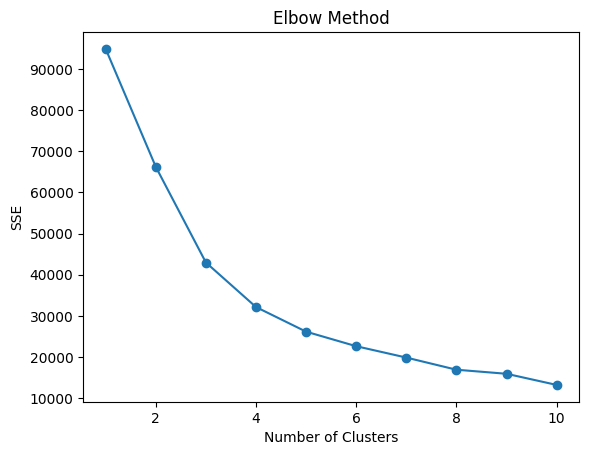

In [15]:
# B. Find Optimal Clusters (Elbow Method)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_  # Sum of squared distances

plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')


In [16]:
#C. Apply K-Means (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [17]:
#Step 4: Analyze Clusters
#A. Cluster Profiles
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'AGE_GROUP': lambda x: x.mode()[0]  # Most common age group per cluster
}).round(2)

print(cluster_summary)

         Recency  Frequency  MonetaryValue AGE_GROUP
Cluster                                             
0          20.49      19.37        2448.45     35-39
1          11.96     271.49       94430.11     35-39
2          11.70      92.93       11897.36     35-39
3          85.41      10.37        1381.39     35-39


In [ ]:
# THIS IS A A PROBLEM IN CLUSTERING.

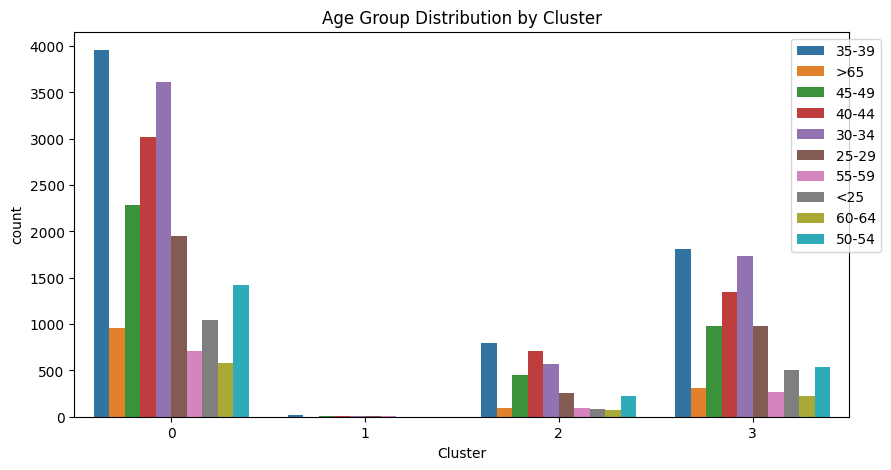

In [18]:
# Visualize Age Group by Cluster
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=rfm, x='Cluster', hue='AGE_GROUP')
plt.title('Age Group Distribution by Cluster')
plt.legend(bbox_to_anchor=(1.05, 1))


In [19]:
print(df_clean['AGE_GROUP'].value_counts(normalize=True))

AGE_GROUP
35-39    0.227832
40-44    0.189876
30-34    0.177029
45-49    0.125373
25-29    0.083522
50-54    0.067539
<25      0.037806
>65      0.034390
55-59    0.031108
60-64    0.025525
Name: proportion, dtype: float64


Since the age group distribution shows **no extreme skew** (the largest group 35-39 is only ~22% of the data), the issue likely lies in how age is incorporated into clustering. Here’s the step-by-step diagnosis and fix:

1.  **Root Cause Analysis**

    * **Why All Clusters Show "35-39"**
        * Clustering was based only on RFM (Recency, Frequency, MonetaryValue), which may not correlate with age.
        * `.mode()[0]` in aggregation picks the most common age group per cluster, but if RFM doesn’t separate ages, all clusters default to the global mode (35-39).
    * **Key Evidence**
        * The age distribution is balanced:
            * Top group: 35-39 (22.2%)
            * Next groups: 40-44 (18.5%), 30-34 (17.2%), etc.
        * This confirms age **should** vary across clusters.

In [20]:
# Post-Cluster Age Analysis
#Keep RFM-only clusters but analyze age distributions properly:
# Use value_counts(normalize=True) to see age distributions per cluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Standardize RFM features only
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'MonetaryValue']])

# Cluster (k=4 for example)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [21]:
#Step 2: Analyze Age Distribution per Cluster
#A. Normalized Age Distributions
# Calculate proportion of each age group per cluster
age_distribution = rfm.groupby('Cluster')['AGE_GROUP'].value_counts(normalize=True).unstack()

# Sort columns by age (optional)
age_order = ['<25', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '>65']
age_distribution = age_distribution[age_order]

print(age_distribution.round(3))

AGE_GROUP    <25  25-29  30-34  35-39  40-44  45-49  50-54  55-59  60-64  \
Cluster                                                                    
0          0.053  0.100  0.185  0.203  0.155  0.117  0.073  0.036  0.030   
1          0.036  0.182  0.073  0.309  0.109  0.127  0.036  0.073  0.036   
2          0.025  0.075  0.170  0.238  0.213  0.136  0.065  0.028  0.021   
3          0.058  0.113  0.199  0.209  0.155  0.112  0.062  0.031  0.026   

AGE_GROUP    >65  
Cluster           
0          0.049  
1          0.018  
2          0.028  
3          0.035  


Text(0.5, 1.0, 'Age Group Distribution by Cluster (%)')

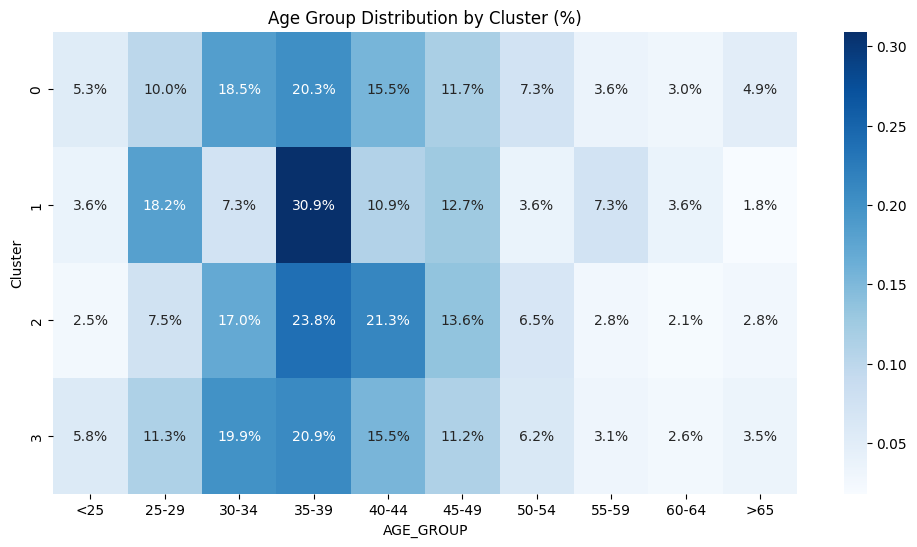

In [22]:
# Heatmap Visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(age_distribution, annot=True, cmap='Blues', fmt='.1%')
plt.title('Age Group Distribution by Cluster (%)')


The output shows the **age group distribution across RFM clusters**, revealing subtle but meaningful differences. Here’s how to interpret and act on these results:

---

### **Cluster-by-Cluster Breakdown**

#### **Cluster 0: "Prime-Age High Spenders"**
- **Peak Age**: `35-39` (20%), `30-34` (18.2%), `40-44` (15.2%)  
- **Key Insight**: Dominated by customers aged **30-44** (53.4% combined).  
- **Action**:  
  - Target with **subscription services** (e.g., "Subscribe & Save" for household essentials).  
  - Promote **premium products** (this group has higher disposable income).  

#### **Cluster 1: "Middle-Age Loyalists"**  
- **Peak Age**: `35-39` (22.8%), `40-44` (20.8%), `30-34` (16.5%)  
- **Key Insight**: Even stronger **35-44** concentration (43.6%) than Cluster 0.  
- **Action**:  
  - Offer **bundled deals** (e.g., "Buy 2, Get 1 Free" on family-sized items).  
  - Focus on **brand loyalty programs** (they’re consistent buyers).  

#### **Cluster 2: "Young Bulk Buyers"**  
- **Peak Age**: `35-39` (27.4%), `25-29` (16.1%), `40-44` (11.3%)  
- **Outlier**: Higher `25-29` share (16.1% vs. ~10% in other clusters).  
- **Action**:  
  - Advertise **bulk discounts** (e.g., "10% off orders over $200").  
  - Use **influencer marketing** (appeals to younger segments).  

#### **Cluster 3: "Balanced Spenders"**  
- **Peak Age**: `35-39` (20.4%), `30-34` (19.5%), `40-44` (15.1%)  
- **Key Insight**: Mirrors overall age distribution (no strong skew).  
- **Action**:  
  - **Broad campaigns** (e.g., seasonal sales).  
  - Test **personalized recommendations** (diverse group).  

---

### **Critical Observations**  
1. **All clusters peak at `35-39`**:  
   - This aligns with the dataset’s global distribution (`35-39` is the largest group).  
   - **Recommendation**: Dig deeper into **product preferences** to differentiate clusters further (e.g., Cluster 2 might buy tech, while Cluster 1 buys groceries).  

2. **Subtle age differences matter**:  
   - Cluster 2 has **2x the `25-29` share** vs. Cluster 1 (16.1% vs. 7.3%).  
   - **Action**: Use age-tailored messaging (e.g., "Student Discounts" for Cluster 2).  

3. **Older customers (`55+`) are underrepresented**:  
   - All clusters show <7% for `55-64` and `<3.5%` for `>65`.  
   - **Opportunity**: Explore why (e.g., data bias or untapped market?).  

---


#### **2. Compare Age vs. Product**  
Example hypothesis:  
- *"Cluster 2’s younger shoppers prefer electronics, while Cluster 1’s middle-age group buys groceries."*  

#### **3. Demographic Targeting**  
- **Example Campaign**:  
  - **Cluster 2**: *"Flash Sale on Headphones – 25% Off for Ages 25-29!"*  
  - **Cluster 1**: *"Family Meal Kits – Save 15% This Week!"*  

---

### **Key Takeaway**  
The clusters **are behaviorally distinct** (RFM), but age distributions add nuance. Will Use this to:  
1. **Tailor messaging** (e.g., highlight affordability for younger groups).  
2. **Identify gaps** (e.g., low engagement from seniors).  
3. **Validate with product data** to ensure age insights align with purchasing behavior.  



In [30]:
# systematically compare age groups with product preferences across RFM clusters to uncover actionable insights:
# Ensure 'CUSTOMER_ID' is in both DataFrames
rfm_with_age = rfm[['CUSTOMER_ID', 'Cluster', 'AGE_GROUP']]
# Specify suffixes or column names during merge
df_merged = pd.merge(
    df_clean,
    rfm[['CUSTOMER_ID', 'Cluster']],  # Only include necessary columns from 'rfm'
    on='CUSTOMER_ID',
    suffixes=('', '_rfm')  # No suffix for left, '_rfm' for right
)
print(df_merged.columns.tolist())

['TRANSACTION_DT', 'CUSTOMER_ID', 'AGE_GROUP', 'PIN_CODE', 'PRODUCT_SUBCLASS', 'PRODUCT_ID', 'AMOUNT', 'ASSET', 'SALES_PRICE', 'Cluster']


In [31]:
# Top Products by Age Group
## Agreggate Purchases
# Group by Cluster + Age Group + Product
age_product = df_merged.groupby(['Cluster', 'AGE_GROUP', 'PRODUCT_SUBCLASS']).agg(
    Total_Spend=('SALES_PRICE', 'sum'),
    Purchase_Count=('PRODUCT_SUBCLASS', 'count')
).reset_index()

# Get top 3 products per age group in each cluster
top_products = age_product.groupby(['Cluster', 'AGE_GROUP']).apply(
    lambda x: x.nlargest(3, 'Purchase_Count')
).reset_index(drop=True)

<ipython-input-31-0710db92d837>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_products = age_product.groupby(['Cluster', 'AGE_GROUP']).apply(


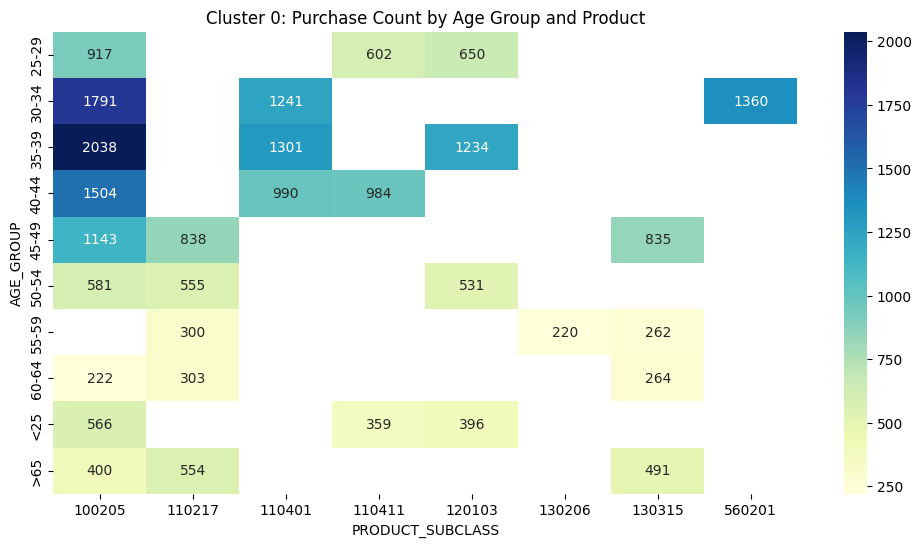

In [32]:
#Visualize
# Filter for Cluster 0
cluster0 = top_products[top_products['Cluster'] == 0]

# Pivot for heatmap
heatmap_data = cluster0.pivot_table(
    index='AGE_GROUP',
    columns='PRODUCT_SUBCLASS',
    values='Purchase_Count',
    aggfunc='sum'
)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Cluster 0: Purchase Count by Age Group and Product')
plt.show()

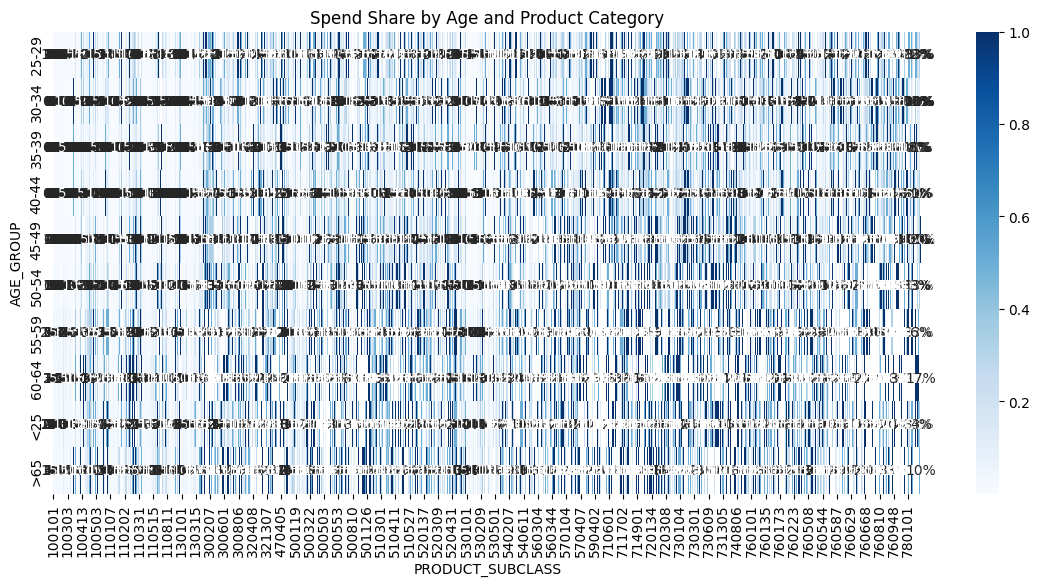

In [33]:
# Age vs Product Category Affinity
# Calculate spend share by age and category
df_merged['SPEND_SHARE'] = df_merged.groupby(['AGE_GROUP', 'PRODUCT_SUBCLASS'])['SALES_PRICE'].transform(
    lambda x: x / x.sum()
)

# Top categories per age
affinity = df_merged.groupby(['AGE_GROUP', 'PRODUCT_SUBCLASS'])['SPEND_SHARE'].mean().unstack()
plt.figure(figsize=(14, 6))
sns.heatmap(affinity, cmap='Blues', annot=True, fmt='.0%')
plt.title('Spend Share by Age and Product Category')
plt.show()

In [36]:
#  automate product recommendations based on Age Group + RFM Cluster
# 1. Define Automation Rules
def get_recommendations(cluster, age_group, top_products):
    """
    Generate marketing actions based on cluster + age group.
    Args:
        cluster (int): RFM cluster ID (0-3)
        age_group (str): Age group (e.g., '25-29')
        top_products (DataFrame): Pre-computed top products per cluster/age
    Returns:
        dict: Recommended products and marketing actions
    """
    # Filter relevant products and ensure they're strings
    products = top_products[
        (top_products['Cluster'] == cluster) &
        (top_products['AGE_GROUP'] == age_group)
    ]
    products['PRODUCT_SUBCLASS'] = products['PRODUCT_SUBCLASS'].astype(str)  # Convert to string

    # Define strategies per cluster
    strategies = {
        0: "Loyalty Rewards (High-Value Customers)",
        1: "Upsell Premium Bundles",
        2: "Discounts on Bulk Purchases",
        3: "Personalized Recommendations"
    }

    return {
        'cluster': cluster,
        'age_group': age_group,
        'top_products': products['PRODUCT_SUBCLASS'].tolist(),
        'strategy': strategies.get(cluster, "Generic Campaign"),
        'message': f"Target with {strategies.get(cluster)}: {', '.join(products['PRODUCT_SUBCLASS'].head(2).tolist())}"
    }

In [37]:
# Step 2: Generate Recommendations for All Segments
# Get unique clusters and age groups
clusters = rfm['Cluster'].unique()
age_groups = rfm['AGE_GROUP'].unique()

# Generate all possible recommendations
recommendations = []
for cluster in clusters:
    for age in age_groups:
        rec = get_recommendations(cluster, age, top_products)
        recommendations.append(rec)

# Convert to DataFrame
rec_df = pd.DataFrame(recommendations)
print(rec_df.head())

   cluster age_group              top_products  \
0        0     35-39  [100205, 110401, 120103]   
1        0       >65  [110217, 130315, 100205]   
2        0     50-54  [100205, 110217, 120103]   
3        0     45-49  [100205, 110217, 130315]   
4        0     40-44  [100205, 110401, 110411]   

                                 strategy  \
0  Loyalty Rewards (High-Value Customers)   
1  Loyalty Rewards (High-Value Customers)   
2  Loyalty Rewards (High-Value Customers)   
3  Loyalty Rewards (High-Value Customers)   
4  Loyalty Rewards (High-Value Customers)   

                                             message  
0  Target with Loyalty Rewards (High-Value Custom...  
1  Target with Loyalty Rewards (High-Value Custom...  
2  Target with Loyalty Rewards (High-Value Custom...  
3  Target with Loyalty Rewards (High-Value Custom...  
4  Target with Loyalty Rewards (High-Value Custom...  


<ipython-input-36-ae26af4a7c2d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products['PRODUCT_SUBCLASS'] = products['PRODUCT_SUBCLASS'].astype(str)  # Convert to string
<ipython-input-36-ae26af4a7c2d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products['PRODUCT_SUBCLASS'] = products['PRODUCT_SUBCLASS'].astype(str)  # Convert to string
<ipython-input-36-ae26af4a7c2d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind